In [37]:
import glob
import numpy as np
import pandas as pd
from astropy.time import Time
import cdflib
import datetime
import spacepy.datamodel as dm
from astropy.table import Table
import math
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import tqdm



def earth_radius(B):
    B = math.radians(B)  # converting into radians
    a = 6378.137  # Radius at sea level at equator
    b = 6356.752  # Radius at poles
    c = (a ** 2 * math.cos(B)) ** 2
    d = (b ** 2 * math.sin(B)) ** 2
    e = (a * math.cos(B)) ** 2
    f = (b * math.sin(B)) ** 2
    R = math.sqrt((c + d) / (e + f))
    return R

def objective(x, a, b):
    return  a*np.exp(b*x)

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

spatial_window = 5
temporal_window = 15
altitude_window = 100

radar_list = glob.glob('../data/external/Madrigal/2018-2021/*/*.hdf5')
radar_list.sort()

gf_list = glob.glob('../data/interim/GRACEFO/KBRNE_relative_v2/dat/*')
gf_list.sort()

headerlist = ['CDF Epoch', 'GPS', 'Latitude', 'Longitude', 'Radius', 'Latitude_QD', 'Longitude_QD',
              'MLT', 'GRACE_1_Position', 'GRACE_2_Position', 'Iono_Corr', 'Distance', 'Relative_Hor_TEC', 'Relative_Ne']

gf_list_datetimes = []
for gf_file in gf_list:
    gf = pd.read_csv(gf_file, sep='\s+', header=0, index_col=False, names=headerlist)
    gf_list_datetimes.append((Time(gf['CDF Epoch'].values[-1], format='cdf_epoch').datetime).strftime('%Y-%m-%d'))



# def find_conjunctions(radar_file, gf_list, gf_list_datetimes):
#     radar_select_0 = []
#     gf_select_0 = []
#     radar_select_1 = []
#     gf_select_1 = []
#     radar_select_2 = []
#     gf_select_2 = []

#     radar_metadata = []
#     gf_file = []
#     Re = []


#     radar = (Table.read(radar_file, path='Data/Table Layout')).to_pandas()
#     radar_date = datetime.datetime(int(radar.year[0]), int(radar.month[0]), int(radar.day[0])).strftime('%Y-%m-%d')

#     date, idx_gf, idx_radar = np.intersect1d(gf_list_datetimes, radar_date, return_indices=True)

#     if len(idx_radar) > 0:


#         gf_file = gf_list[idx_gf[0]]
#         gf = pd.read_csv(gf_file, sep='\s+', header=0, index_col=False, names=headerlist)
#         gf['dates'] = (Time(gf['CDF Epoch'].values, format='cdf_epoch')).datetime

#         radar_metadata = (Table.read(radar_file, path='Metadata/Experiment Parameters')).to_pandas()

#         names = np.array([x.decode() for x in radar_metadata['name']])
#         values = np.array([x.decode() for x in radar_metadata['value']])

#         radar_metadata = pd.DataFrame({'name': names,
#                                        'value': values})
#         radar_lat = float(radar_metadata[radar_metadata['name'] == 'instrument latitude']['value'].values[0])
#         radar_lon = float(radar_metadata[radar_metadata['name'] == 'instrument longitude']['value'].values[0])
#         radar['dates'] = Time(radar[['ut1_unix', 'ut2_unix']].mean(axis=1), format='unix').datetime

#         gf = gf[((gf['Latitude'] <= radar_lat + spatial_window) & (gf['Latitude'] >= radar_lat - spatial_window))]
#         gf = gf[((gf['Longitude'] <= radar_lon + spatial_window) & (gf['Longitude'] >= radar_lon - spatial_window))]

#         if len(gf) > 0:

#             gf_pass = gf[gf.diff(axis=0)['dates'] > datetime.timedelta(minutes=temporal_window)]

#             if len(gf_pass) == 0:  # only one passage

#                 time_window_i = gf['dates'][gf.index.min()] - datetime.timedelta(minutes=temporal_window)
#                 time_window_f = gf['dates'][gf.index.max()] + datetime.timedelta(minutes=temporal_window)

#                 radar['dates'] = Time(radar[['ut1_unix', 'ut2_unix']].mean(axis=1), format='unix').datetime

#                 radar_select_0 = radar[(radar['dates'] >= time_window_i) & (radar['dates'] <= time_window_f)]
#                 gf_select_0 = gf[(gf['dates'] >= time_window_i) & (gf['dates'] <= time_window_f)]

#                 if len(radar_select_0) > 0:
#                     Re = earth_radius(radar_lat)
#                     altitude = np.mean(gf_select_0['Radius'] * 0.001 - Re)

#                     altitude_window_i = altitude - altitude_window
#                     altitude_window_f = altitude + altitude_window

#                     radar_select_0 = radar_select_0[
#                         (radar_select_0['gdalt'] >= altitude_window_i) & (radar_select_0['gdalt'] <= altitude_window_f)]


#             if len(gf_pass) == 1:  # two passages

#                 pass_idx = gf[gf['dates'] == gf_pass['dates'][gf_pass.index.min()]].index[0]

#                 # first one

#                 # define time window
#                 time_window_i = gf['dates'][gf.index.min()] - datetime.timedelta(minutes=15)
#                 time_window_f = gf['dates'][
#                                     gf.index[np.argwhere(gf.index == pass_idx)[0][0] - 1]] + datetime.timedelta(
#                     minutes=15)

#                 radar_select_1 = radar[(radar['dates'] >= time_window_i) & (radar['dates'] <= time_window_f)]
#                 gf_select_1 = gf[(gf['dates'] >= time_window_i) & (gf['dates'] <= time_window_f)]

#                 if len(radar_select_1) > 0:
#                     Re = earth_radius(radar_lat)
#                     altitude = np.mean(gf_select_1['Radius'] * 0.001 - Re)

#                     altitude_window_i = altitude - altitude_window
#                     altitude_window_f = altitude + altitude_window

#                     radar_select_1 = radar_select_1[
#                         (radar_select_1['gdalt'] >= altitude_window_i) & (radar_select_1['gdalt'] <= altitude_window_f)]


#                 # second one

#                 # define time window
#                 time_window_i = gf['dates'][gf.index[np.argwhere(gf.index == pass_idx)[0][0]]] - datetime.timedelta(
#                     minutes=15)
#                 time_window_f = gf['dates'][gf.index.max()] + datetime.timedelta(minutes=15)

#                 radar_select_2 = radar[(radar['dates'] >= time_window_i) & (radar['dates'] <= time_window_f)]
#                 gf_select_2 = gf[(gf['dates'] >= time_window_i) & (gf['dates'] <= time_window_f)]

#                 if len(radar_select_2) > 0:
#                     Re = earth_radius(radar_lat)
#                     altitude = np.mean(gf_select_2['Radius'] * 0.001 - Re) # 0.001 convert m to km

#                     altitude_window_i = altitude - altitude_window
#                     altitude_window_f = altitude + altitude_window

#                     radar_select_2 = radar_select_2[
#                         (radar_select_2['gdalt'] >= altitude_window_i) & (radar_select_2['gdalt'] <= altitude_window_f)]


#     return radar_select_0,gf_select_0,radar_select_1,gf_select_1,radar_select_2,gf_select_2,radar_metadata, gf_file, Re

# # radar_metadata[radar_metadata['name'] == 'Cedar file name']['value']
# # gf_file.split('/')[-1]

# def calc_conjunctions(radar_select, gf_select,Re):
#     radar_select['nel'] = np.log10(radar_select['ne'])
#     gf_select['Relative_Nel'] = np.log10(gf_select['Relative_Ne'])

#     radar_mean = radar_select.groupby(['gdalt']).mean()

#     gf_alt = np.mean(gf_select['Radius'] * 0.001 - Re)
#     gf_nel = np.mean(gf_select['Relative_Nel'])


#     x = radar_mean['nel'].values
#     y = radar_mean.index.values

#     # curve fit
#     popt, _ = curve_fit(objective, x, y, maxfev=10000)
#     a, b = popt
#     #         print(popt)

#     # define a sequence of inputs between the smallest and largest known inputs
#     x_line = np.arange(min(x), max(x), 10e-6)
#     # calculate the output for the range
#     y_line = objective(x_line, a, b)

#     idx = find_nearest_idx(y_line,gf_alt)
#     radar_alt = y_line[idx]
#     radar_nel = x_line[idx]
#     plt.scatter(radar_nel, gf_nel)
#     return radar_nel,gf_nel

# fig, ax = plt.subplots(figsize=(10,10))
# plt.plot([0,15],[0,15], color='k')
# plt.xlim(0,15)
# plt.ylim(0,15)

# # n=0
# for i in iter(range(0,len(radar_list))):
#     # print(i)
# # i = 1515
#     try:
#         radar_select_0,gf_select_0,radar_select_1,gf_select_1,radar_select_2,gf_select_2,radar_metadata, gf_file, Re = find_conjunctions(radar_file= radar_list[i], gf_list = gf_list, gf_list_datetimes = gf_list_datetimes)


#         if (len(radar_select_0) > 0) & (len(gf_select_0) > 0):
#             # print('0 GF passage ', gf_select_0['dates'][gf_select_0.index == gf_select_0.index.min()].values, '->', gf_select_0['dates'][gf_select_0.index == gf_select_1.index.max()].values)
#             # print('gf : ', len(gf_select_0))
#             # print('radar : ',len(np.unique(radar_select_0['recno'])))
#             # print('------')
#             radar_nel_0,gf_nel_0 = calc_conjunctions(radar_select_0, gf_select_0, Re)
#             # n = n+1

#         if (len(radar_select_1) > 0) & (len(gf_select_1) > 0):
#             # print('1 GF passage ', gf_select_1['dates'][gf_select_1.index == gf_select_1.index.min()].values, '->', gf_select_1['dates'][gf_select_1.index == gf_select_1.index.max()].values)
#             # print('gf : ', len(gf_select_1))
#             # print('radar : ',len(np.unique(radar_select_1['recno'])))
#             # print('------')
#             radar_nel_1,gf_nel_1 =calc_conjunctions(radar_select_1, gf_select_1, Re)
#             # n = n + 1

#         if (len(radar_select_2) > 0) & (len(gf_select_2) > 0):
#             # print('2 GF passage ', gf_select_2['dates'][gf_select_2.index == gf_select_2.index.min()].values, '->', gf_select_2['dates'][gf_select_2.index == gf_select_2.index.max()].values)
#             # print('gf : ', len(gf_select_2))
#             # print('radar : ', len(np.unique(radar_select_2['recno'])))
#             # print('------')
#             radar_nel_2,gf_nel_2 =calc_conjunctions(radar_select_2, gf_select_2, Re)
#                     # n = n + 1
#     except:
#         pass

# plt.show()
# # print(i)

In [31]:
gf_file = gf_list[100]

In [32]:
gf = pd.read_csv(gf_file, sep='\s+', header=0, index_col=False, names=headerlist)


In [33]:
gf['dates'] = (Time(gf['CDF Epoch'].values, format='cdf_epoch')).datetime

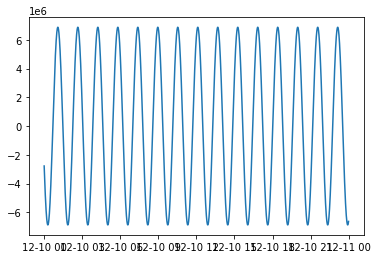

In [34]:
# plt.plot(np.log10(gf['Relative_Ne']))
plt.plot(gf['dates'],gf['Relative_Ne'])

In [35]:
gf_file

'../data/interim/GRACEFO/KBRNE_relative_v2/dat/GF_OPER_NE__KBR_2F_20181210T000000_20181210T235959_0101.dat'

In [36]:
gf

,CDF Epoch,GPS,Latitude,Longitude,Radius,Latitude_QD,Longitude_QD,MLT,GRACE_1_Position,GRACE_2_Position,Iono_Corr,Distance,Relative_Hor_TEC,Relative_Ne,dates
0,63711619182000,1228435200,-24.656,-46.007,6867498.21,-21.035,20.601,20.38,4307690.2,-4459307.7,-2954697.3,4362390.4,-4521134.8,-2775179.0,2018-12-09 23:59:42
1,63711619187000,1228435205,-24.974,-46.022,6867505.06,-21.279,20.532,20.37,4295147.9,-4448507.8,-2989051.7,4350516.2,-4511071.4,-2809994.3,2018-12-09 23:59:47
2,63711619192000,1228435210,-25.292,-46.036,6867511.99,-21.522,20.464,20.37,4282482.1,-4437562.5,-3023314.0,4338516.2,-4500861.1,-2844722.9,2018-12-09 23:59:52
3,63711619197000,1228435215,-25.610,-46.050,6867519.02,-21.765,20.397,20.37,4269693.1,-4426472.0,-3057483.0,4326390.7,-4490504.2,-2879363.7,2018-12-09 23:59:57
4,63711619202000,1228435220,-25.928,-46.064,6867526.13,-22.009,20.331,20.36,4256781.5,-4415236.6,-3091557.7,4314140.3,-4480000.8,-2913915.7,2018-12-10 00:00:02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17275,63711705557000,1228521575,-75.035,128.765,6875093.21,-88.837,-64.105,14.71,-1176407.3,1454340.2,-6616533.9,-1046868.2,1314282.9,-6667268.2,2018-12-10 23:59:17
17276,63711705562000,1228521580,-74.718,128.826,6875146.02,-88.797,-79.933,13.66,-1200725.1,1481622.4,-6606159.8,-1071415.3,1341737.7,-6657947.7,2018-12-10 23:59:22
17277,63711705567000,1228521585,-74.402,128.883,6875198.91,-88.674,-93.801,12.74,-1224986.6,1508877.3,-6595583.6,-1095910.0,1369169.7,-6648423.5,2018-12-10 23:59:27
17278,63711705572000,1228521590,-74.086,128.937,6875251.87,-88.489,-104.819,12.00,-1249191.1,1536104.0,-6584805.7,-1120351.3,1396577.9,-6638696.0,2018-12-10 23:59:32


In [38]:
radar_list[0]

'../data/external/Madrigal/2018-2021/AreciboISRadar-Gregorian/aro20180115clpg.000.hdf5'

In [39]:
radar_metadata = (Table.read(radar_list[0], path='Metadata/Experiment Parameters')).to_pandas()

In [40]:
radar_metadata

,name,value
0,b'instrument',b'Arecibo IS Radar - Gregorian'
1,b'instrument code(s)',b'21'
2,b'kind of data file',b'Coded long pulse mode'
3,b'kindat code(s)',b'2020'
4,b'start time',b'2018-01-15 19:31:36 UT'
5,b'end time',b'2018-01-15 22:59:34 UT'
6,b'Cedar file name',b'/opt/madrigal3/experiments3/2018/arg/15jan18...
7,b'status description',b'Preliminary'
8,b'instrument latitude',b'18.345'
9,b'instrument longitude',b'293.25'


In [44]:
radar_metadata['value'][0]

b'Arecibo IS Radar - Gregorian'

In [ ]:
import glob
import numpy as np
import pandas as pd
from astropy.time import Time
import cdflib
import datetime
import spacepy.datamodel as dm
from astropy.table import Table
import math
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import tqdm



def earth_radius(B):
    B = math.radians(B)  # converting into radians
    a = 6378.137  # Radius at sea level at equator
    b = 6356.752  # Radius at poles
    c = (a ** 2 * math.cos(B)) ** 2
    d = (b ** 2 * math.sin(B)) ** 2
    e = (a * math.cos(B)) ** 2
    f = (b * math.sin(B)) ** 2
    R = math.sqrt((c + d) / (e + f))
    return R

def objective(x, a, b):
    return  a*np.exp(b*x)

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

spatial_window = 5
temporal_window = 15
altitude_window = 100

radar_list = glob.glob('../data/external/Madrigal/2018-2021/*/*.hdf5')
radar_list.sort()

gf_list = glob.glob('../data/interim/GRACEFO/KBRNE_relative_v1/dat/*')
gf_list.sort()

headerlist = ['CDF Epoch', 'GPS', 'Latitude', 'Longitude', 'Radius', 'Latitude_QD', 'Longitude_QD',
              'MLT', 'GRACE_1_Position', 'GRACE_2_Position', 'Iono_Corr', 'Distance', 'Relative_Hor_TEC', 'Relative_Ne']

gf_list_datetimes = []
for gf_file in gf_list:
    gf = pd.read_csv(gf_file, sep='\s+', header=0, index_col=False, names=headerlist)
    gf_list_datetimes.append((Time(gf['CDF Epoch'].values[-1], format='cdf_epoch').datetime).strftime('%Y-%m-%d'))



def find_conjunctions(radar_file, gf_list, gf_list_datetimes):
    radar_select_0 = []
    gf_select_0 = []
    radar_select_1 = []
    gf_select_1 = []
    radar_select_2 = []
    gf_select_2 = []

    radar_metadata = []
    gf_file = []
    Re = []


    radar = (Table.read(radar_file, path='Data/Table Layout')).to_pandas()
    radar_date = datetime.datetime(int(radar.year[0]), int(radar.month[0]), int(radar.day[0])).strftime('%Y-%m-%d')

    date, idx_gf, idx_radar = np.intersect1d(gf_list_datetimes, radar_date, return_indices=True)

    if len(idx_radar) > 0:


        gf_file = gf_list[idx_gf[0]]
        gf = pd.read_csv(gf_file, sep='\s+', header=0, index_col=False, names=headerlist)
        gf['dates'] = (Time(gf['CDF Epoch'].values, format='cdf_epoch')).datetime

        radar_metadata = (Table.read(radar_file, path='Metadata/Experiment Parameters')).to_pandas()

        names = np.array([x.decode() for x in radar_metadata['name']])
        values = np.array([x.decode() for x in radar_metadata['value']])

        radar_metadata = pd.DataFrame({'name': names,
                                       'value': values})
        radar_lat = float(radar_metadata[radar_metadata['name'] == 'instrument latitude']['value'].values[0])
        radar_lon = float(radar_metadata[radar_metadata['name'] == 'instrument longitude']['value'].values[0])
        radar['dates'] = Time(radar[['ut1_unix', 'ut2_unix']].mean(axis=1), format='unix').datetime

        gf = gf[((gf['Latitude'] <= radar_lat + spatial_window) & (gf['Latitude'] >= radar_lat - spatial_window))]
        gf = gf[((gf['Longitude'] <= radar_lon + spatial_window) & (gf['Longitude'] >= radar_lon - spatial_window))]

        if len(gf) > 0:

            gf_pass = gf[gf.diff(axis=0)['dates'] > datetime.timedelta(minutes=temporal_window)]

            if len(gf_pass) == 0:  # only one passage

                time_window_i = gf['dates'][gf.index.min()] - datetime.timedelta(minutes=temporal_window)
                time_window_f = gf['dates'][gf.index.max()] + datetime.timedelta(minutes=temporal_window)

                radar['dates'] = Time(radar[['ut1_unix', 'ut2_unix']].mean(axis=1), format='unix').datetime

                radar_select_0 = radar[(radar['dates'] >= time_window_i) & (radar['dates'] <= time_window_f)]
                gf_select_0 = gf[(gf['dates'] >= time_window_i) & (gf['dates'] <= time_window_f)]

                if len(radar_select_0) > 0:
                    Re = earth_radius(radar_lat)
                    altitude = np.mean(gf_select_0['Radius'] * 0.001 - Re)

                    altitude_window_i = altitude - altitude_window
                    altitude_window_f = altitude + altitude_window

                    radar_select_0 = radar_select_0[
                        (radar_select_0['gdalt'] >= altitude_window_i) & (radar_select_0['gdalt'] <= altitude_window_f)]


            if len(gf_pass) == 1:  # two passages

                pass_idx = gf[gf['dates'] == gf_pass['dates'][gf_pass.index.min()]].index[0]

                # first one

                # define time window
                time_window_i = gf['dates'][gf.index.min()] - datetime.timedelta(minutes=15)
                time_window_f = gf['dates'][
                                    gf.index[np.argwhere(gf.index == pass_idx)[0][0] - 1]] + datetime.timedelta(
                    minutes=15)

                radar_select_1 = radar[(radar['dates'] >= time_window_i) & (radar['dates'] <= time_window_f)]
                gf_select_1 = gf[(gf['dates'] >= time_window_i) & (gf['dates'] <= time_window_f)]

                if len(radar_select_1) > 0:
                    Re = earth_radius(radar_lat)
                    altitude = np.mean(gf_select_1['Radius'] * 0.001 - Re)

                    altitude_window_i = altitude - altitude_window
                    altitude_window_f = altitude + altitude_window

                    radar_select_1 = radar_select_1[
                        (radar_select_1['gdalt'] >= altitude_window_i) & (radar_select_1['gdalt'] <= altitude_window_f)]


                # second one

                # define time window
                time_window_i = gf['dates'][gf.index[np.argwhere(gf.index == pass_idx)[0][0]]] - datetime.timedelta(
                    minutes=15)
                time_window_f = gf['dates'][gf.index.max()] + datetime.timedelta(minutes=15)

                radar_select_2 = radar[(radar['dates'] >= time_window_i) & (radar['dates'] <= time_window_f)]
                gf_select_2 = gf[(gf['dates'] >= time_window_i) & (gf['dates'] <= time_window_f)]

                if len(radar_select_2) > 0:
                    Re = earth_radius(radar_lat)
                    altitude = np.mean(gf_select_2['Radius'] * 0.001 - Re) # 0.001 convert m to km

                    altitude_window_i = altitude - altitude_window
                    altitude_window_f = altitude + altitude_window

                    radar_select_2 = radar_select_2[
                        (radar_select_2['gdalt'] >= altitude_window_i) & (radar_select_2['gdalt'] <= altitude_window_f)]


    return radar_select_0,gf_select_0,radar_select_1,gf_select_1,radar_select_2,gf_select_2,radar_metadata, gf_file, Re

# radar_metadata[radar_metadata['name'] == 'Cedar file name']['value']
# gf_file.split('/')[-1]

def calc_conjunctions(radar_select, gf_select,Re):
    radar_select['nel'] = np.log10(radar_select['ne'])
    gf_select['Relative_Nel'] = np.log10(gf_select['Relative_Ne'])

    radar_mean = radar_select.groupby(['gdalt']).mean()

    gf_alt = np.mean(gf_select['Radius'] * 0.001 - Re)
    gf_nel = np.mean(gf_select['Relative_Nel'])


    x = radar_mean['nel'].values
    y = radar_mean.index.values

    # curve fit
    popt, _ = curve_fit(objective, x, y, maxfev=10000)
    a, b = popt
    #         print(popt)

    # define a sequence of inputs between the smallest and largest known inputs
    x_line = np.arange(min(x), max(x), 10e-6)
    # calculate the output for the range
    y_line = objective(x_line, a, b)

    idx = find_nearest_idx(y_line,gf_alt)
    radar_alt = y_line[idx]
    radar_nel = x_line[idx]
    plt.scatter(radar_nel, gf_nel)
    return radar_nel,gf_nel

fig, ax = plt.subplots(figsize=(10,10))
plt.plot([0,15],[0,15], color='k')
plt.xlim(0,15)
plt.ylim(0,15)

# n=0
names = []
for i in iter(range(0,len(radar_list))):
    # print(i)
# i = 1515
    try:
        radar_select_0,gf_select_0,radar_select_1,gf_select_1,radar_select_2,gf_select_2,radar_metadata, gf_file, Re = find_conjunctions(radar_file= radar_list[i], gf_list = gf_list, gf_list_datetimes = gf_list_datetimes)


        if (len(radar_select_0) > 0) & (len(gf_select_0) > 0):
            # print('0 GF passage ', gf_select_0['dates'][gf_select_0.index == gf_select_0.index.min()].values, '->', gf_select_0['dates'][gf_select_0.index == gf_select_1.index.max()].values)
            # print('gf : ', len(gf_select_0))
            # print('radar : ',len(np.unique(radar_select_0['recno'])))
            # print('------')
            names.append(radar_metadata[radar_metadata['name'] == 'instrument']['value'][0])
            # radar_nel_0,gf_nel_0 = calc_conjunctions(radar_select_0, gf_select_0, Re)
            # n = n+1

        if (len(radar_select_1) > 0) & (len(gf_select_1) > 0):
            # print('1 GF passage ', gf_select_1['dates'][gf_select_1.index == gf_select_1.index.min()].values, '->', gf_select_1['dates'][gf_select_1.index == gf_select_1.index.max()].values)
            # print('gf : ', len(gf_select_1))
            # print('radar : ',len(np.unique(radar_select_1['recno'])))
            # print('------')
            names.append(radar_metadata[radar_metadata['name'] == 'instrument']['value'][0])
            # radar_nel_1,gf_nel_1 =calc_conjunctions(radar_select_1, gf_select_1, Re)
            # n = n + 1

        if (len(radar_select_2) > 0) & (len(gf_select_2) > 0):
            # print('2 GF passage ', gf_select_2['dates'][gf_select_2.index == gf_select_2.index.min()].values, '->', gf_select_2['dates'][gf_select_2.index == gf_select_2.index.max()].values)
            # print('gf : ', len(gf_select_2))
            # print('radar : ', len(np.unique(radar_select_2['recno'])))
            # print('------')
            names.append(radar_metadata[radar_metadata['name'] == 'instrument']['value'][0])
            # radar_nel_2,gf_nel_2 =calc_conjunctions(radar_select_2, gf_select_2, Re)
                    # n = n + 1
    except:
        pass

# plt.show()
# print(i)
names = pd.DataFrame(data={"name": names})
names.to_csv('names.csv')


In [3]:
import glob
radar_list = glob.glob('../data/external/Madrigal/2018-2021/*/*.hdf5')
radar_list.sort()

radar_list 

['../data/external/Madrigal/2018-2021/AreciboISRadar-Gregorian/aro20180115clpg.000.hdf5',
 '../data/external/Madrigal/2018-2021/AreciboISRadar-Gregorian/aro20180115plg.001.hdf5',
 '../data/external/Madrigal/2018-2021/AreciboISRadar-Gregorian/aro20180116clpg.000.hdf5',
 '../data/external/Madrigal/2018-2021/AreciboISRadar-Gregorian/aro20180116plg.001.hdf5',
 '../data/external/Madrigal/2018-2021/AreciboISRadar-Gregorian/aro20180117clpg.000.hdf5',
 '../data/external/Madrigal/2018-2021/AreciboISRadar-Gregorian/aro20180117plg.001.hdf5',
 '../data/external/Madrigal/2018-2021/AreciboISRadar-Gregorian/aro20180129plg.001.hdf5',
 '../data/external/Madrigal/2018-2021/AreciboISRadar-Gregorian/aro20180130plg.001.hdf5',
 '../data/external/Madrigal/2018-2021/AreciboISRadar-Gregorian/aro20180131plg.001.hdf5',
 '../data/external/Madrigal/2018-2021/AreciboISRadar-Gregorian/aro20180201plg.001.hdf5',
 '../data/external/Madrigal/2018-2021/AreciboISRadar-Gregorian/aro20180202plg.001.hdf5',
 '../data/external

In [4]:
import glob

In [8]:
radars = glob.glob('../data/external/Madrigal/2018-2021/*')

In [13]:
for r in radars:
#     print(r.split('/')[-1])
    print(glob.glob('../data/external/Madrigal/2018-2021/' + r.split('/')[-1] + '/*'))

['../data/external/Madrigal/2018-2021/JicamarcaISRadar/jro2019-10-22_1810.001.hdf5', '../data/external/Madrigal/2018-2021/JicamarcaISRadar/jro20190102drifts_avg.001.hdf5', '../data/external/Madrigal/2018-2021/JicamarcaISRadar/jro20181004drifts.001.hdf5', '../data/external/Madrigal/2018-2021/JicamarcaISRadar/jro20180724drifts.001.hdf5', '../data/external/Madrigal/2018-2021/JicamarcaISRadar/jro20181107drifts.001.hdf5', '../data/external/Madrigal/2018-2021/JicamarcaISRadar/jro20180404drifts_avg.001.hdf5', '../data/external/Madrigal/2018-2021/JicamarcaISRadar/jro20181003a.001.hdf5', '../data/external/Madrigal/2018-2021/JicamarcaISRadar/jro20181228drifts.001.hdf5', '../data/external/Madrigal/2018-2021/JicamarcaISRadar/jro20200923drifts_avg.001.hdf5', '../data/external/Madrigal/2018-2021/JicamarcaISRadar/jro20191205a.001.hdf5', '../data/external/Madrigal/2018-2021/JicamarcaISRadar/jro20200117drifts_avg.001.hdf5', '../data/external/Madrigal/2018-2021/JicamarcaISRadar/jro20180403drifts.001.hdf